<a href="https://colab.research.google.com/github/KiarashVaziri/DL-Homework3/blob/main/Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [23]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
from torchvision.models import resnet18, resnet50, ResNet50_Weights
import torch.optim as optim
from torch.autograd import Variable

In [13]:
import copy
from collections import defaultdict
from tqdm import tqdm

In [4]:
!mkdir models

# Load Data

In [5]:
batch_size = 64
learning_rate = 3e-3
num_epochs = 5

In [24]:
data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

weight_transform = ResNet50_Weights.IMAGENET1K_V2.transforms()

data_sets = {
    'train' : datasets.CIFAR10(root='.', download=True, train=True, transform=weight_transform), 
    'test' : datasets.CIFAR10(root='.', download=True, train=False, transform=weight_transform)
}

Files already downloaded and verified
Files already downloaded and verified


In [25]:
print(data_sets['train'])
print('='*85)
print(data_sets['test'])

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


In [8]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(data_sets['train'],
                                batch_size=batch_size,
                                shuffle=True),
    'test':
    torch.utils.data.DataLoader(data_sets['test'],
                                batch_size=batch_size,
                                shuffle=False)
}

In [9]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


# Part a

## Load Pretrained Model

In [15]:
model = models.resnet50(weights="IMAGENET1K_V2")
model = model.to(device)

# model = model.cuda() if use_cuda else model
for param in model.parameters():
  param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(data_sets['train'].classes))
model.fc = model.fc.cuda() if use_cuda else model.fc

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.fc.parameters())
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Linear-tuning

In [16]:
train_acces, test_acces = [], []
train_losses, test_losses = [], []
total_step = len(dataloaders['train'])
test_loss_min = np.Inf

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}\n')

    network_learned = False

    for phase in ['train', 'test']:

        running_loss = 0.0
        running_corrects = 0

        if phase == 'train':
            model.train()

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):

                if use_cuda:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
  
                inputs = inputs.float()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                if (batch_idx) % 50 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, batch_idx, total_step, loss.item()))
            # scheduler.step()
        else:
            with torch.no_grad():
                model.eval()
                for inputs, labels in dataloaders[phase]:
                    if use_cuda:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    inputs = inputs.float()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
            network_learned = running_loss < test_loss_min
            test_loss_min = running_loss if network_learned else test_loss_min


        epoch_loss = running_loss / len(data_sets[phase])
        epoch_acc = running_corrects.double() / len(data_sets[phase])
        
        if phase == 'train':
            train_acces.append(epoch_acc * 100)
            train_losses.append(epoch_loss)
        else:
            test_acces.append(epoch_acc * 100)
            test_losses.append(epoch_loss)
    print(f'\ntrain-loss: {np.mean(train_losses):.4f}, train-acc: {train_acces[-1]:.4f}')
    print(f'test loss: {np.mean(test_losses):.4f}, test acc: {test_acces[-1]:.4f}\n')

    if network_learned:
        torch.save(model.state_dict(), 'models/weights.h5')
        print('Improvement-Detected, save-model')

Epoch 1

Epoch [1/5], Step [0/782], Loss: 2.3243
Epoch [1/5], Step [50/782], Loss: 1.2613
Epoch [1/5], Step [100/782], Loss: 1.0883
Epoch [1/5], Step [150/782], Loss: 0.8777
Epoch [1/5], Step [200/782], Loss: 0.9000
Epoch [1/5], Step [250/782], Loss: 0.8162
Epoch [1/5], Step [300/782], Loss: 0.7409
Epoch [1/5], Step [350/782], Loss: 0.6171
Epoch [1/5], Step [400/782], Loss: 0.7349
Epoch [1/5], Step [450/782], Loss: 0.7545
Epoch [1/5], Step [500/782], Loss: 0.6001
Epoch [1/5], Step [550/782], Loss: 0.7314
Epoch [1/5], Step [600/782], Loss: 0.8116
Epoch [1/5], Step [650/782], Loss: 0.8530
Epoch [1/5], Step [700/782], Loss: 0.8925
Epoch [1/5], Step [750/782], Loss: 0.7279

train-loss: 0.0131, train-acc: 73.7760
test loss: 0.0095, test acc: 79.7700

Improvement-Detected, save-model
Epoch 2

Epoch [2/5], Step [0/782], Loss: 0.4103
Epoch [2/5], Step [50/782], Loss: 0.5892
Epoch [2/5], Step [100/782], Loss: 0.6609
Epoch [2/5], Step [150/782], Loss: 0.5420
Epoch [2/5], Step [200/782], Loss: 0.

In [17]:
train_accuracy = np.array([acc.cpu().numpy() for acc in train_acces])
test_accuracy = np.array([acc.cpu().numpy() for acc in test_acces])

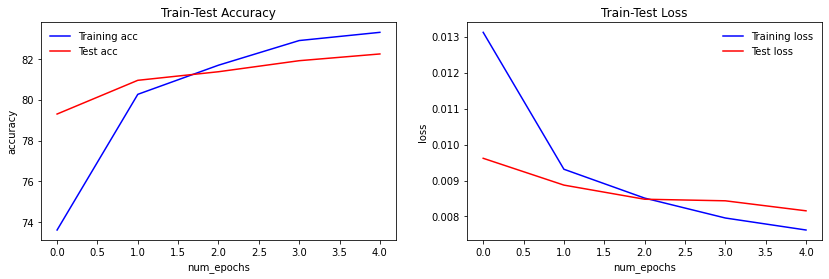

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(121)
plt.title("Train-Test Accuracy")
plt.plot(train_accuracy, color='blue', label='Training acc')
plt.plot(test_accuracy, color='red', label='Test acc')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.legend(frameon=False)

plt.subplot(122)
plt.title("Train-Test Loss")
plt.plot(train_losses, color='blue', label='Training loss')
plt.plot(test_losses, color='red', label='Test loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(frameon=False)

plt.show()

In [18]:
teacher_model = model

## Evaluation
The pretrained model of ResNet50 achieves test accuracy **%82.24** on CIFAR10. 

# Part b

## Define Knowledge Distillation Loss Function

In [65]:
def loss_kd(student_outputs, labels, teacher_outputs, temparature=1, alpha=0.5):
  teacher_s = F.softmax(teacher_outputs / temparature, dim=1)
  student_s = F.softmax(student_outputs / temparature, dim=1)
  d_loss = (teacher_s * torch.log(student_s)).sum(axis=1).mean()
  normal_loss = nn.CrossEntropyLoss()(student_outputs, labels)
  return (1-alpha) * normal_loss - alpha * (temparature ** 2) * d_loss

## Load Student and Teacher Models

In [66]:
num_epochs = 5
alpha, T = 0.5, 8
max_lr = 0.01
weight_decay = 1e-4

In [69]:
student_model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
student_model.fc = nn.Linear(in_features=num_ftrs, out_features=len(data_sets['train'].classes))
params = student_model.parameters()

optimizer = optim.Adam(params, max_lr, weight_decay=weight_decay)
sched = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, 
                                            steps_per_epoch=len(dataloaders['train']))

train_acces, test_acces = [], []
train_losses, test_losses = [], []
total_step = len(dataloaders['train'])
test_loss_min = np.Inf

## Train

In [70]:
student_model.to(device)
teacher_model.to(device)

for epoch in range(1, num_epochs+1):
  for phase in ['train', 'test']:
    if phase == 'train':
      model.train()
    else:
      model.eval()
    data = tqdm(dataloaders[phase])
    n_data = 0
    correct_all = 0
    loss_all = 0

    for X, y in data:
        n_data += X.shape[0]
        X = X.to(device)
        y = y.to(device)
        pred = student_model(X)
        pred_t = teacher_model(X)
        loss = loss_kd(pred, y, pred_t, temparature=T, alpha=alpha)

        if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if sched is not None:
              sched.step()

        pred = pred.argmax(axis=1)
        correct_all += (pred == y).sum().item()
        loss_all += loss.item()
        epoch_acc = correct_all/n_data
        epoch_loss = loss_all/n_data
        data.set_description(f'Epoch [{epoch}/{num_epochs}], {phase } loss: {epoch_loss:.4f}, {phase} accuracy: {100*epoch_acc:.2f}%')
    if phase == 'train':
        train_acces.append(epoch_acc*100)
        train_losses.append(epoch_loss)
    else:
        test_acces.append(epoch_acc*100)
        test_losses.append(epoch_loss)

Epoch [1/5], train loss: 1.1367, train accuracy: 53.21%: 100%|██████████| 782/782 [06:13<00:00,  2.09it/s]
Epoch [1/5], test loss: 1.1390, test accuracy: 58.98%: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch [2/5], train loss: 1.1291, train accuracy: 66.45%: 100%|██████████| 782/782 [06:12<00:00,  2.10it/s]
Epoch [2/5], test loss: 1.1325, test accuracy: 69.12%: 100%|██████████| 157/157 [00:55<00:00,  2.85it/s]
Epoch [3/5], train loss: 1.1258, train accuracy: 72.96%: 100%|██████████| 782/782 [06:12<00:00,  2.10it/s]
Epoch [3/5], test loss: 1.1286, test accuracy: 76.39%: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch [4/5], train loss: 1.1225, train accuracy: 79.05%: 100%|██████████| 782/782 [06:12<00:00,  2.10it/s]
Epoch [4/5], test loss: 1.1261, test accuracy: 81.18%: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
Epoch [5/5], train loss: 1.1191, train accuracy: 86.53%: 100%|██████████| 782/782 [06:14<00:00,  2.09it/s]
Epoch [5/5], test loss: 1.1242, test accuracy

## Results

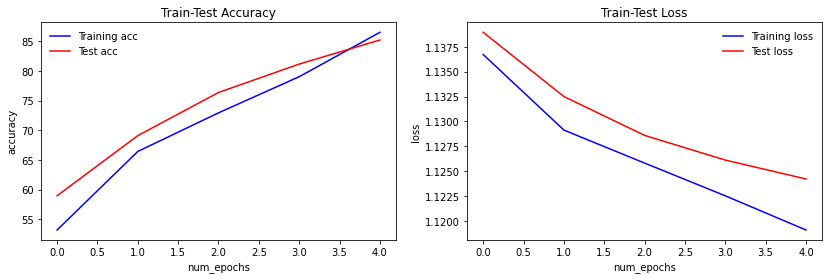

In [78]:
plt.figure(figsize=(14,4))

plt.subplot(121)
plt.title("Train-Test Accuracy")
plt.plot(train_accuracy, color='blue', label='Training acc')
plt.plot(test_accuracy, color='red', label='Test acc')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.legend(frameon=False)

plt.subplot(122)
plt.title("Train-Test Loss")
plt.plot(train_losses, color='blue', label='Training loss')
plt.plot(test_losses, color='red', label='Test loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(frameon=False)

plt.show()

We can observe that the test accuracy increases with teacher-student approach up to **%85.24**

NOTE: For different pairs of tau and alpha, training process was conducted for 2 epochs and out of all tested pairs, the best result has been obtained with **(α,τ)=(0.5, 8)**.

# Part c


In [80]:
num_epochs = 5
max_lr = 0.01
weight_decay = 1e-4

In [81]:
student_model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
student_model.fc = nn.Linear(in_features=num_ftrs, out_features=len(data_sets['train'].classes))
params = student_model.parameters()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params, max_lr, weight_decay=weight_decay)
sched = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, 
                                            steps_per_epoch=len(dataloaders['train']))


train_acces, test_acces = [], []
train_losses, test_losses = [], []
total_step = len(dataloaders['train'])
test_loss_min = np.Inf

In [82]:
student_model.to(device)

for epoch in range(1, num_epochs+1):
  for phase in ['train', 'test']:
    if phase == 'train':
      model.train()
    else:
      model.eval()
    data = tqdm(dataloaders[phase])
    n_data = 0
    correct_all = 0
    loss_all = 0

    for X, y in data:
        n_data += X.shape[0]
        X = X.to(device)
        y = y.to(device)
        pred = student_model(X)
        loss = criterion(pred, y)

        if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if sched is not None:
              sched.step()

        pred = pred.argmax(axis=1)
        correct_all += (pred == y).sum().item()
        loss_all += loss.item()
        epoch_acc = correct_all/n_data
        epoch_loss = loss_all/n_data
        data.set_description(f'Epoch [{epoch}/{num_epochs}], {phase } loss: {epoch_loss:.4f}, {phase} accuracy: {100*epoch_acc:.2f}%')

    if phase == 'train':
        train_acces.append(epoch_acc*100)
        train_losses.append(epoch_loss)
    else:
        test_acces.append(epoch_acc*100)
        test_losses.append(epoch_loss)

Epoch [1/5], train loss: 0.0214, train accuracy: 50.56%: 100%|██████████| 782/782 [03:48<00:00,  3.42it/s]
Epoch [1/5], test loss: 0.0180, test accuracy: 60.42%: 100%|██████████| 157/157 [00:25<00:00,  6.05it/s]
Epoch [2/5], train loss: 0.0166, train accuracy: 62.59%: 100%|██████████| 782/782 [03:46<00:00,  3.45it/s]
Epoch [2/5], test loss: 0.0173, test accuracy: 60.87%: 100%|██████████| 157/157 [00:25<00:00,  6.06it/s]
Epoch [3/5], train loss: 0.0142, train accuracy: 68.35%: 100%|██████████| 782/782 [03:46<00:00,  3.45it/s]
Epoch [3/5], test loss: 0.0126, test accuracy: 72.21%: 100%|██████████| 157/157 [00:25<00:00,  6.07it/s]
Epoch [4/5], train loss: 0.0107, train accuracy: 76.37%: 100%|██████████| 782/782 [03:44<00:00,  3.48it/s]
Epoch [4/5], test loss: 0.0094, test accuracy: 79.50%: 100%|██████████| 157/157 [00:25<00:00,  6.07it/s]
Epoch [5/5], train loss: 0.0068, train accuracy: 85.12%: 100%|██████████| 782/782 [03:45<00:00,  3.47it/s]
Epoch [5/5], test loss: 0.0075, test accuracy

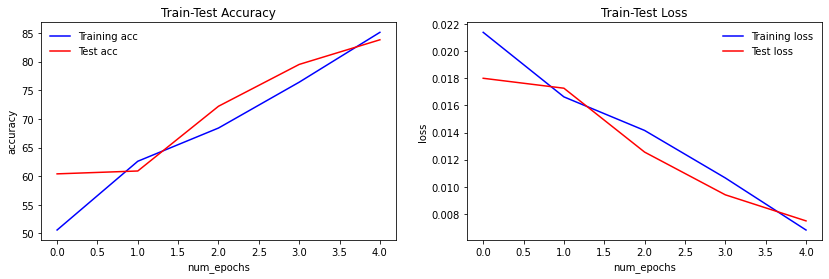

In [85]:
plt.figure(figsize=(14,4))

plt.subplot(121)
plt.title("Train-Test Accuracy")
plt.plot(train_accuracy, color='blue', label='Training acc')
plt.plot(test_accuracy, color='red', label='Test acc')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.legend(frameon=False)

plt.subplot(122)
plt.title("Train-Test Loss")
plt.plot(train_losses, color='blue', label='Training loss')
plt.plot(test_losses, color='red', label='Test loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(frameon=False)

plt.show()

## Evaluation
It can be observed that after the same number of epochs of training, the plain ResNet18 model reaches the test accuracy of **%83.77** which is less that the obtained results with teacher-student approach. The reason for this difference is because in the teacher-student approach, we exploit the knowledge of the teacher model which significantly boosts the training process.

# Part d

In [ ]:
model = models.resnet50(weights="IMAGENET1K_V2")
model = model.to(device)

# model = model.cuda() if use_cuda else model
for param in model.parameters():
  param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(data_sets['train'].classes))
model.fc = model.fc.cuda() if use_cuda else model.fc

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.fc.parameters())
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
train_acces, test_acces = [], []
train_losses, test_losses = [], []
total_step = len(dataloaders['train'])
test_loss_min = np.Inf

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}\n')

    network_learned = False

    for phase in ['train', 'test']:

        running_loss = 0.0
        running_corrects = 0

        if phase == 'train':
            model.train()

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):

                if use_cuda:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
  
                inputs = inputs.float()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                if (batch_idx) % 50 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, batch_idx, total_step, loss.item()))
            # scheduler.step()
        else:
            with torch.no_grad():
                model.eval()
                for inputs, labels in dataloaders[phase]:
                    if use_cuda:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    inputs = inputs.float()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
            network_learned = running_loss < test_loss_min
            test_loss_min = running_loss if network_learned else test_loss_min


        epoch_loss = running_loss / len(data_sets[phase])
        epoch_acc = running_corrects.double() / len(data_sets[phase])
        
        if phase == 'train':
            train_acces.append(epoch_acc * 100)
            train_losses.append(epoch_loss)
        else:
            test_acces.append(epoch_acc * 100)
            test_losses.append(epoch_loss)
    print(f'\ntrain-loss: {np.mean(train_losses):.4f}, train-acc: {train_acces[-1]:.4f}')
    print(f'test loss: {np.mean(test_losses):.4f}, test acc: {test_acces[-1]:.4f}\n')

    if network_learned:
        torch.save(model.state_dict(), 'models/weights.h5')
        print('Improvement-Detected, save-model')

Epoch 1

Epoch [1/5], Step [0/782], Loss: 2.3014
Epoch [1/5], Step [50/782], Loss: 1.1933
Epoch [1/5], Step [100/782], Loss: 1.1938
Epoch [1/5], Step [150/782], Loss: 0.8970
Epoch [1/5], Step [200/782], Loss: 0.8951
Epoch [1/5], Step [250/782], Loss: 0.8039
Epoch [1/5], Step [300/782], Loss: 0.5827
Epoch [1/5], Step [350/782], Loss: 0.8965
Epoch [1/5], Step [400/782], Loss: 0.7538
Epoch [1/5], Step [450/782], Loss: 0.6157
Epoch [1/5], Step [500/782], Loss: 0.6850
Epoch [1/5], Step [550/782], Loss: 0.6595
Epoch [1/5], Step [600/782], Loss: 0.6970
Epoch [1/5], Step [650/782], Loss: 0.6258
Epoch [1/5], Step [700/782], Loss: 0.7607
Epoch [1/5], Step [750/782], Loss: 0.6276

train-loss: 0.0131, train-acc: 74.0000
test loss: 0.0098, test acc: 78.6100

Improvement-Detected, save-model
Epoch 2

Epoch [2/5], Step [0/782], Loss: 0.7132
Epoch [2/5], Step [50/782], Loss: 0.5674
Epoch [2/5], Step [100/782], Loss: 0.6670
Epoch [2/5], Step [150/782], Loss: 0.7004
Epoch [2/5], Step [200/782], Loss: 0.

In [ ]:
train_accuracy = np.array([acc.cpu().numpy() for acc in train_acces])
test_accuracy = np.array([acc.cpu().numpy() for acc in test_acces])

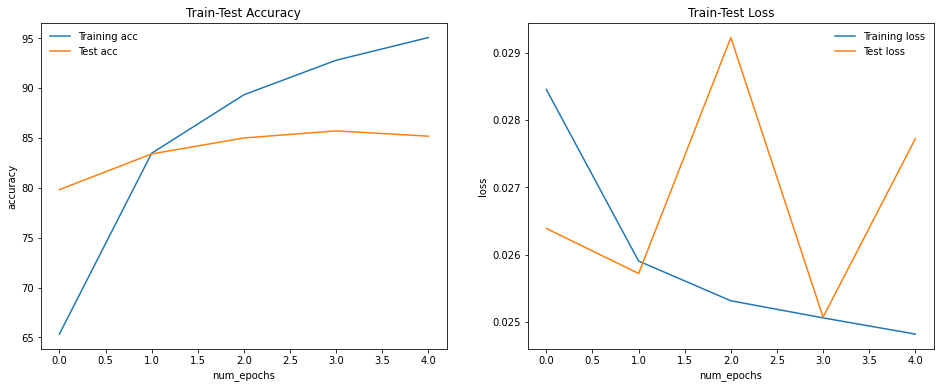

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(121)
plt.title("Train-Test Accuracy")
plt.plot(train_accuracy, color='blue', label='Training acc')
plt.plot(test_accuracy, color='red', label='Test acc')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.legend(frameon=False)

plt.subplot(122)
plt.title("Train-Test Loss")
plt.plot(train_losses, color='blue', label='Training loss')
plt.plot(test_losses, color='red', label='Test loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(frameon=False)

plt.show()

## Evaluation
To train the ResNet50 model from the scratch resulted in test accuracy of **%84.20**, however, the training process was tedious and took an enormous amount of time since the parameters in all layers were also updated at each iteration.